In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

%matplotlib inline

/Users/zytec/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 探索数据集

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

In [3]:
df_train.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test.head(1)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_test.values.max()

255

In [6]:
df_train.iloc[:, 0].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

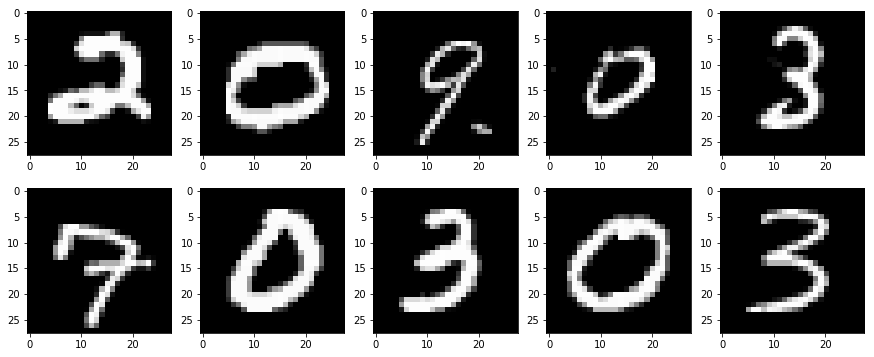

In [7]:
example_imgs = df_test.iloc[:10].values.reshape(-1, 28, 28)

plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['image.cmap'] = 'gray'
for index, img in enumerate(example_imgs):
    plt.subplot(2, 5, index+1)
    plt.imshow(img)

## 划分数据集

In [26]:
X_total = df_train.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
Y_total = df_train.iloc[:, 0].values.reshape(-1, 1)
X_test = df_test.values.reshape(-1, 28, 28, 1)

X_total.shape, Y_total.shape, X_test.shape

((42000, 28, 28, 1), (42000, 1), (28000, 28, 28, 1))

In [27]:
shuffle_indexs = np.random.permutation(X_total.shape[0])
X_total_shuffle = X_total[shuffle_indexs]
Y_total_shuffle = Y_total[shuffle_indexs]

In [28]:
dev_size = 6000

X_dev = X_total_shuffle[:dev_size]
Y_dev = Y_total_shuffle[:dev_size]
X_train = X_total_shuffle[dev_size:]
Y_train = Y_total_shuffle[dev_size:]

Text(0.5,1,'0')

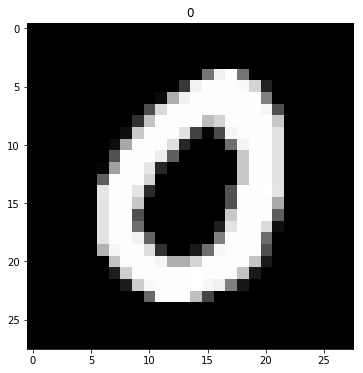

In [195]:
index = np.random.randint(X_train.shape[0])
plt.imshow(X_train[index, :, :, 0])
plt.title(Y_train[index, 0])

## 数据生成器

#### 数据增强

In [29]:
def data_augmentation(X, Y=None):
    if Y is None:
        return X
    else:
        return X, Y

#### 数据归一化

In [30]:
def normalize_data(X, Y=None):
    if Y is None:
        return X / 255
    else:
        return X / 255, Y

In [31]:
def parser(X, Y=None):    
    if Y is None:
        X = data_augmentation(X)
        X = normalize_data(X)
        return X
    else:
        X, Y = data_augmentation(X, Y)
        X, Y = normalize_data(X, Y)
        return X, Y

#### mini batch 生成器

In [32]:
def batch_gen(X, Y, batch_size, repeat=1, num_parallels=4):
    m = X.shape[0]
    steps = m // batch_size
    
    if m % batch_size:
        steps += 1
    
    if Y is None:
        dataset = tf.data.Dataset.from_tensor_slices(X)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(parser, num_parallels)
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.repeat(repeat)
    
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next(), steps

## 构建神经网络

In [74]:
def build_placeholder():
    with tf.name_scope('input_placeholder'):
        X = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1), name='input_X')
        Y = tf.placeholder(dtype=tf.int32, shape=(None, 1), name='lable_Y')
        training = tf.placeholder(dtype=tf.bool, name='training')
    
    return X, Y, training

In [202]:
def build_conv_layer(inputs, training, keep_prob, filters, kernel_size, strides, name):
    with tf.name_scope('conv_layer_' + name):
        Z = tf.layers.conv2d(inputs, filters=filters, kernel_size=kernel_size, strides=strides, 
                             padding='same', use_bias=False, 
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        Z_batch_norm = tf.layers.batch_normalization(inputs, training=training)
        
        A = tf.nn.relu(Z_batch_norm)
        
        A_dropout = tf.nn.dropout(A, keep_prob)
        
    return A_dropout

In [203]:
def build_max_pool(inputs, pool_size, strides, name):
    with tf.name_scope('max_pool_' + name):
        pool = tf.layers.max_pooling2d(inputs, pool_size, strides, name='max_pool')
        
    return pool

In [204]:
def build_flatten_layer(inputs):
    with tf.name_scope('flatten_layer'):
        flatten = tf.layers.flatten(inputs)
        
    return flatten

In [205]:
def build_softmax_layer(inputs):
    with tf.name_scope('softmax_layer'):
        Z = tf.layers.dense(inputs, 10, kernel_initializer=tf.contrib.layers.xavier_initializer())
        A = tf.nn.softmax(Z)
        
    return Z, A

In [206]:
def build_cost(logits, labels):
    with tf.name_scope('cost'):
        labels_onehot = tf.one_hot(labels, 10, axis=-1)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels_onehot, logits=logits))
    
    return cost

In [207]:
def build_accuracy(outputs, labels):
    with tf.name_scope('accuracy'):
        predicts = tf.argmax(outputs, axis=-1, output_type=tf.int32)
        is_rights = tf.equal(predicts, tf.reshape(labels, (-1,)))
        accuracy = tf.reduce_mean(tf.cast(is_rights, tf.float32))
    
    return accuracy

In [208]:
def build_foreward(X, Y, training, keep_prob):    
    conv1 = build_conv_layer(X, training, keep_prob, 8, (3, 3), (1, 1), '1')
    conv2 = build_conv_layer(conv1, training, keep_prob, 8, (3, 3), (1, 1), '2')
    max_pool2 = build_max_pool(conv2, (2, 2), (2, 2), '2')
    
    conv3 = build_conv_layer(max_pool2, training, keep_prob, 16, (3, 3), (1, 1), '3')
    
    flatten = build_flatten_layer(conv3)
    
    logits, outputs = build_softmax_layer(flatten)
    
    return logits, outputs

In [209]:
def train(lr, keep_prob, batch_size, epochs, print_step, metrics_step, resume=True):
    tf.reset_default_graph()
    
    X_pl, Y_pl, training_pl = build_placeholder()
    logits_op, outputs_op = build_foreward(X_pl, Y_pl, training_pl, keep_prob)
    cost_op = build_cost(logits_op, Y_pl)
    accuracy_op = build_accuracy(outputs_op, Y_pl)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer_op = tf.train.AdamOptimizer(lr).minimize(cost_op)
    
    train_next_op, train_steps_per_epoch = batch_gen(X_train, Y_train, batch_size, epochs)
    dev_next_op, _ = batch_gen(X_dev, Y_dev, batch_size, epochs)
    
    sess = tf.Session()
    
    sess.run(tf.global_variables_initializer())
    
    epoch = 1
    step = 1
    costs = []
    
    try:
        while True:
            train_X_batch, train_Y_batch = sess.run(train_next_op)

            _, cost, train_batch_accuracy = sess.run((optimizer_op, cost_op, accuracy_op), feed_dict={
                X_pl: train_X_batch,
                Y_pl: train_Y_batch,
                training_pl: True
            })
            
            if step % print_step == 0:
                print('epoch:{0}--step:{1}--cost:{2:.4f}-accuracy:%{3:.2f}'.format(
                    epoch, step, cost, train_batch_accuracy * 100))
                
            if step % metrics_step == 0:
                costs.append(cost)
            
            step += 1
            if step % train_steps_per_epoch == 0:
                epoch += 1
    except tf.errors.OutOfRangeError:
        pass
    
    plt.plot(list(range(1, len(costs) * metrics_step, metrics_step)), costs)
    
    sess.close()

epoch:1--step:200--cost:2.1401-accuracy:%18.75
epoch:1--step:400--cost:2.1792-accuracy:%18.75
epoch:1--step:600--cost:1.8721-accuracy:%37.50
epoch:1--step:800--cost:1.7096-accuracy:%37.50
epoch:1--step:1000--cost:1.6327-accuracy:%43.75
epoch:1--step:1200--cost:1.5362-accuracy:%37.50
epoch:1--step:1400--cost:1.2249-accuracy:%62.50
epoch:1--step:1600--cost:1.6241-accuracy:%68.75
epoch:1--step:1800--cost:1.2150-accuracy:%62.50
epoch:1--step:2000--cost:0.9160-accuracy:%81.25
epoch:1--step:2200--cost:1.0963-accuracy:%62.50
epoch:2--step:2400--cost:1.0551-accuracy:%75.00
epoch:2--step:2600--cost:0.7902-accuracy:%75.00
epoch:2--step:2800--cost:0.9494-accuracy:%75.00
epoch:2--step:3000--cost:0.8913-accuracy:%75.00
epoch:2--step:3200--cost:0.5176-accuracy:%87.50
epoch:2--step:3400--cost:0.5506-accuracy:%87.50
epoch:2--step:3600--cost:0.5935-accuracy:%87.50
epoch:2--step:3800--cost:0.6882-accuracy:%75.00
epoch:2--step:4000--cost:0.6129-accuracy:%75.00
epoch:2--step:4200--cost:0.5447-accuracy:%81

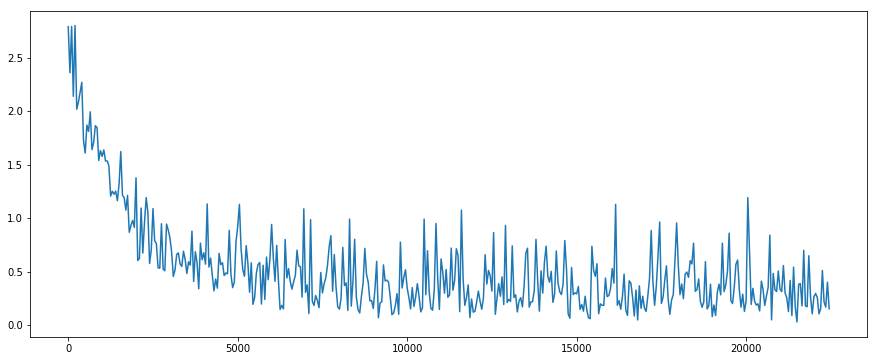

In [211]:
train(lr=0.0001, keep_prob=1, batch_size=16, epochs=10, print_step=500, metrics_step=50, resume=False)